## Import Libraries

In [33]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

## Data preprocessing

### Read data

In [34]:
stock_ntr = pd.read_csv('../../../Dataset/NTR.csv')
stock_ntr

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,46.209999,46.990002,45.855000,46.259998,40.076595,1289100
1,2019-01-03,46.000000,46.099998,44.882999,45.049999,39.028339,1158800
2,2019-01-04,45.950001,47.180000,45.880001,47.130001,40.830315,1538500
3,2019-01-07,47.310001,48.110001,46.840000,47.740002,41.358772,954700
4,2019-01-08,48.709999,49.480000,48.520000,49.209999,42.632286,1921800
...,...,...,...,...,...,...,...
1114,2023-06-06,53.000000,57.294998,52.820000,57.220001,57.220001,6397900
1115,2023-06-07,57.610001,59.750000,57.520000,59.340000,59.340000,2925500
1116,2023-06-08,59.400002,60.080002,57.910000,58.939999,58.939999,2828400
1117,2023-06-09,58.959999,59.349998,58.290001,58.790001,58.790001,1686600


### Reset index

In [35]:
# Convert the 'Date' column to datetime format
stock_ntr['Date'] = pd.to_datetime(stock_ntr['Date'])

# Set the 'Date' column as the index value
stock_ntr = stock_ntr.set_index(pd.DatetimeIndex(stock_ntr['Date'].values))

# Create new datafram with Date and Close
stock_ntr = pd.DataFrame(stock_ntr, columns=['Close'])

### Convert from Series to Supervised

In [36]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [37]:
# n_in : 5  : Observation in the past
n_in = 5
# n_out: 1: Predict in the future
n_out = 1

In [38]:
# Get Values
values = stock_ntr.values

# Convert to supervised
data_supervised = series_to_supervised(values, n_in, n_out)

### Data splitting

In [39]:
# Length
    # Train: 60%
    # Val: 20%
    # Test: 20%
train_size = int(len(stock_ntr) * 0.6)
val_size = int(len(stock_ntr) * 0.2)
test_size = len(stock_ntr) - train_size - val_size

In [40]:
# Get Data
train_data = data_supervised[:train_size]
val_data = data_supervised[train_size:train_size+val_size]
test_data = data_supervised[train_size+val_size:]

# Make input
X_train, y_train = train_data[:, :-n_out], train_data[:, -n_out:]
X_val, y_val = val_data[:, :-n_out], val_data[:, -n_out:]
X_test, y_test = test_data[:, :-n_out], test_data[:, -n_out:]

## Model training and testing

In [41]:
# Define Model
    # objective: Config Loss Function: mean squared error (MSE)
    # n_estimators: Number Of Decision Tree: 1000
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators= 1000, 
)

In [42]:
# Training XgBoost model
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds = 10)

[0]	validation_0-rmse:65.01833
[1]	validation_0-rmse:52.69147
[2]	validation_0-rmse:44.12887
[3]	validation_0-rmse:38.06108
[4]	validation_0-rmse:34.17844
[5]	validation_0-rmse:31.14379
[6]	validation_0-rmse:28.68424
[7]	validation_0-rmse:26.93143
[8]	validation_0-rmse:26.46265
[9]	validation_0-rmse:25.54609
[10]	validation_0-rmse:24.83315
[11]	validation_0-rmse:24.62083
[12]	validation_0-rmse:24.17357
[13]	validation_0-rmse:24.01949
[14]	validation_0-rmse:23.90063
[15]	validation_0-rmse:23.80885
[16]	validation_0-rmse:23.70472
[17]	validation_0-rmse:23.63111
[18]	validation_0-rmse:23.59485
[19]	validation_0-rmse:23.56539
[20]	validation_0-rmse:23.55283
[21]	validation_0-rmse:23.48713
[22]	validation_0-rmse:23.48737
[23]	validation_0-rmse:23.47227
[24]	validation_0-rmse:23.46391
[25]	validation_0-rmse:23.45884
[26]	validation_0-rmse:23.45594
[27]	validation_0-rmse:23.45410
[28]	validation_0-rmse:23.45363
[29]	validation_0-rmse:23.44993
[30]	validation_0-rmse:23.44927
[31]	validation_0-

n:\UIThoc\Nam3\Anaconda\envs\user_env\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Testing process

In [43]:
# Predict
y_pred = model.predict(X_test)

### Evaluate model

In [44]:
# Evaluate the accuracy of test
test_mape = mean_absolute_percentage_error(y_pred, y_test)
test_mse = mean_squared_error(y_pred, y_test)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred, y_test)

print(f"Testing MAPE: ", test_mape)
print(f"Testing RMSE: ", test_rmse)
print(f"Testing MSLE: ", test_msle)

Testing MAPE:  0.24472595034616196
Testing RMSE:  17.483132137552577
Testing MSLE:  0.055471453463536824


## Predicting the next 30 days

### Preparing the prediction data

In [45]:
future_features = data_supervised[:, :-n_out] 

prediction_next30_days = []  # Danh sách dự đoán giá Close

for _ in range(30):
    # Predict Close 
    y_pred_30day = model.predict(future_features)
    prediction_next30_days.append(y_pred_30day[0])  # Get values

    # Create a new data for input of model
    future_features = np.roll(future_features, -1, axis=1)
    future_features[:, -1] = y_pred_30day

In [46]:
# Print predict next 30 days
print(prediction_next30_days)

[49.459316, 49.544376, 49.082607, 48.885227, 49.010643, 48.898483, 49.07998, 49.098404, 49.098404, 49.098404, 49.098404, 49.098404, 49.098404, 49.098404, 49.098404, 49.098404, 49.098404, 49.098404, 49.098404, 49.098404, 49.098404, 49.098404, 49.098404, 49.098404, 49.098404, 49.098404, 49.098404, 49.098404, 49.098404, 49.098404]


### Preparing the forecast date index

In [47]:
# Get the last date from the current index
last_date = stock_ntr.index.max()

# Create a list of indices starting from the next date for 30 days
future_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=30, freq='D')

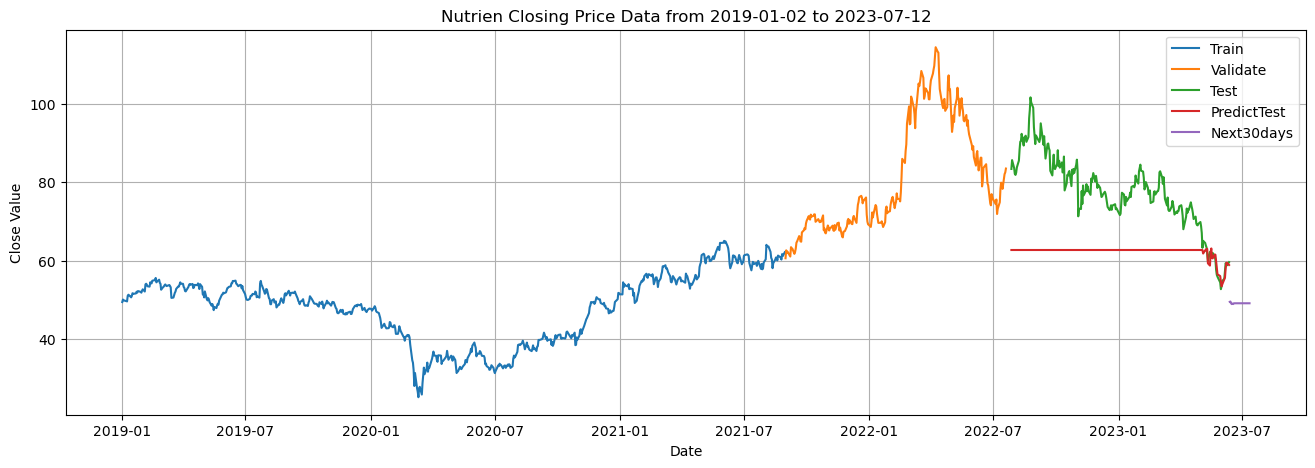

In [48]:
plt.figure(figsize=(16,5))

plt.plot(stock_ntr.index[:train_size], y_train)

plt.plot(stock_ntr.index[train_size: train_size + val_size], y_val)

plt.plot(stock_ntr.index[train_size + val_size + n_in: train_size + test_size + val_size], y_test)

plt.plot(stock_ntr.index[train_size + val_size + n_in: train_size + test_size + val_size], y_pred)

plt.plot(future_dates, prediction_next30_days)

plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Nutrien Closing Price Data from 2019-01-02 to 2023-07-12')
plt.legend(['Train','Validate','Test','PredictTest','Next30days'])
plt.grid()
plt.savefig('../Image/XgBoost_622_NTR.png')
plt.show()